# [IAPR 2020:][iapr2020] Lab 2 ‒  Object description

**Authors:** first_name_1 last_name_1, first_name_2 last_name_2, first_name_3 last_name_3  
**Due date:** 24.04.2020

[iapr2020]: https://github.com/LTS5/iapr-2020

## Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1
In the `lab-02-data/part1` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try first the Fourier Descriptors.
You can make several attempts: e.g. with and without invariance to rotation, translation, scaling, etc.
You can also for instance rotate the images and assess the invariance in rotation.

**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point.
Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

Then feel free to try other features, the more you try, the better it will be (for you).

### 1.1 Data visualization

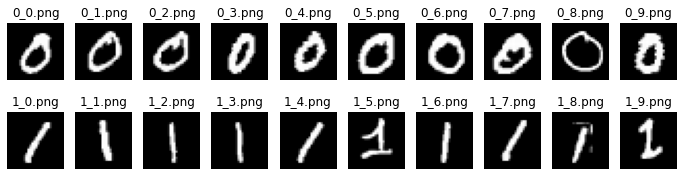

In [2]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load images
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
#  Load zeros
zeros_path = os.path.join(data_base_path, data_folder, 'part1', '0')
zeros_names = [nm for nm in os.listdir(zeros_path) if '.png' in nm]  # make sure to only load .png
zeros_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(zeros_path, nm) for nm in zeros_names])
zeros_im = skimage.io.concatenate_images(ic)
#  Load ones
ones_path = os.path.join(data_base_path, data_folder, 'part1', '1')
ones_names = [nm for nm in os.listdir(ones_path) if '.png' in nm]  # make sure to only load .png
ones_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(ones_path, nm) for nm in ones_names]))
ones_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 1.2 Fourier descriptors
Add your implementation and discussion

### 1.3 Additional method(s)
Add your implementation and discussion

#### 1.3.3 Moments

Another region-based descriptor that we use in this lab are the $2^{nd}$ order moments known as the moments of inertia. We use the central (aka centered) $2^{nd}$ moments, namely, $\mu_{0,2}$ and $\mu_{2,0}$ to construct the image descriptor. As we saw in the lecture, these image moments are invariant to translation. These moments may be used to determine an important image feature, _orientation_. In general, the orientation of an image describes how the image lies in the field of view or the directions of the principal axes.

In the code below, we use the centered moments $\mu_{2,0}$ and $\mu_{0,2}$ to construct image descriptors to be able to extract a 2D feature vector. To this end, we compute the second order centered moments along X and Y.

In [13]:
import cv2
import math
import numpy as np

def compute_moments(images):
    """
    Calculates the 2nd order centered moments and moment invariants of the image

    Parameters
    ----------
    images : numpy.ndarray
        images 
   
    Returns
    -------
    tuple
        2nd order central moments
    list 
        list of moment invariants 
    """
    # Definition of centered moments (the notation follows that of the lecture slides) for images
    mu_02=[]
    mu_20=[]
    
    # Compute the centerd moment along X and Y for images
    for im in images:
        moments = cv2.moments(im);
        mu_20.append(moments["mu20"])
        mu_02.append(moments["mu02"])
        
    centered_moments_vec = (mu_20,mu_02)
    return centered_moments_vec

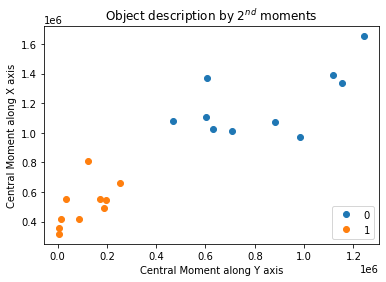

In [19]:
# Compute the 2nd order centerd moments for zeros  
centered_moments_vec_zeros= compute_moments(zeros_im)


# Compute the 2nd order centerd moments for ones 
centered_moments_vec_ones = compute_moments(ones_im)

# Plot the centered moments resutls
zeros_c = plt.plot(centered_moments_vec_zeros[0],centered_moments_vec_zeros[1],"o",label="0")
ones_c  = plt.plot(centered_moments_vec_ones [0],centered_moments_vec_ones [1],"o",label="1")

plt.xlabel('Central Moment along Y axis')
plt.ylabel('Central Moment along X axis')
plt.title('Object description by $2^{nd}$ moments')
plt.legend(loc=4)

plt.show()


__Conclusions__: According to the above plot, we can see that the centered moment along X and Y of zeros and ones images give descriptive features in order to perform clustering. We can see that zeros have higher $2^{nd}$ moments along both X and Y axes and this is fully explained by the shape of Zeros as they are wider than ones and thus have higher second moment along Y axis. Also, in zeros, we have two pixels for every X and thus zeros have higher moment of intertia in X direction. Another observation is that the $2^{nd}$ moment of zeros along both X and Y have more variance than ones and this is due to the fact that, in general, zeros have more pixels away from each of the axes than ones and this makes their $2^{nd}$ moments be more sensitive to small changes. 

#### 1.3.4 Histogram of Oriented Gradients

The histogram of oriented gradients (HOG) is a feature descriptor. It counts the occurrences of gradient orientation in various parts of the image. In order to find the occurrences (i.e., histogarm) of gradient orientation, we use a cell that moves within the image. The resulting histogram of all gradient orientation will be the image descriptor.
The methos has the following stesp:

1. Divide the image into small connected regions called cells, and for each cell compute a histogram of gradient directions or edge orientations for the pixels within the cell.

2. Discretize each cell into angular bins according to the gradient orientation.

3. Each cell's pixel contributes weighted gradient to its corresponding angular bin.

4. Groups of adjacent cells are considered as spatial regions called blocks. The grouping of cells into a block is the basis for grouping and normalization of histograms.

5. Normalized group of histograms represents the block histogram. The set of these block histograms represents the descriptor.

6. Use PCA to pick the first 2 most important features (i.e., the first two principle components)

We use a block size of 8x8, cell size of 2x2, and a stride of 4x4. Smaller block and cell sizes help find more features. However, too small cell and block sizes used can result in a too sensitive descriptive model and hence would give erroneous features. 

In [5]:
from sklearn.decomposition import PCA
import numpy as np 


def compute_HoG_descriptor(images, HoG_descriptor):
    """
    Calculates Histogram of Oriented Gradients of the image to find the features of the images.

    Parameters
    ----------
    images : numpy.ndarray
        images 
    HoG_descriptor: cv2.HOGDescriptor
        HoG  ddescriptor object 
   
    Returns
    -------
    list
        list of features

    """
    # List of features
    features = []
    
    # Compute the HoG description of images
    for im in images:
        descriptions = HoG_descriptor.compute(im)
        
        # Normalize 
        normalized = [item for sublist in descriptions for item in sublist]
        features.append(normalized)

    return features
    

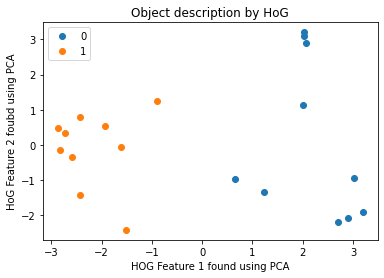

In [6]:
# All features list
all_features = []

# Calculate HoG descriptor with window size of 8x8, cell size of 2x2, and stride of 4x4
HoG_descriptor = cv2.HOGDescriptor((28,28),(8,8),(4,4),(2,2),8)

# Compute the HoG description of zeros  
features_zeros = compute_HoG_descriptor(zeros_im, HoG_descriptor)
all_features.append(features_zeros)

# Compute the HoG description of ones  
features_ones = compute_HoG_descriptor(ones_im, HoG_descriptor)
all_features.append(features_ones)

# Reshape the features vector from 3D to 2D 
all_features = np.reshape(all_features,(np.shape(all_features)[0]*np.shape(all_features)[1],np.shape(all_features)[2]))

# Combine the features using PCA
pca = PCA(n_components=2)
features_2d = pca.fit_transform(all_features)

# Plot the results
zeros = plt.plot(features_2d.transpose()[0][10:20],features_2d.transpose()[1][10:20],"o", label="0")
ones = plt.plot(features_2d.transpose()[0][0:10],features_2d.transpose()[1][0:10], "o", label="1")

plt.xlabel('HOG Feature 1 found using PCA')
plt.ylabel('HoG Feature 2 foubd using PCA')
plt.title('Object description by HoG')
plt.legend(loc=2)

plt.show()

__Conclusion:__ According to the above plot, we can see that, compared to the previous methods, the points in the two clusters are further apart and we have larger various in them. The larger variance among the zero image instances in the above plot is due to the fact that zeros are more sensitive to scaling than ones. 

## Part 2
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

### 2.1 Data visualization

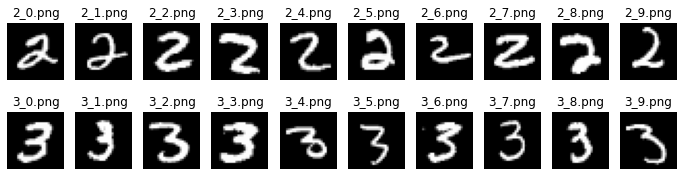

In [7]:
#  Load zeros
twos_path = os.path.join(data_base_path, data_folder, 'part2', '2')
twos_names = [nm for nm in os.listdir(twos_path) if '.png' in nm]  # make sure to only load .png
twos_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(twos_path, nm) for nm in twos_names])
twos_im = skimage.io.concatenate_images(ic)
#  Load ones
threes_path = os.path.join(data_base_path, data_folder, 'part2', '3')
threes_names = [nm for nm in os.listdir(threes_path) if '.png' in nm]  # make sure to only load .png
threes_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(threes_path, nm) for nm in threes_names]))
threes_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 2.2 Additional method(s) and conclusion
Add your implementations and discussions here

#### 2.3.3 Moments

Here we use the moments method described in section 1.3.3 to construct image descriptors for images of 2's and 3's. 

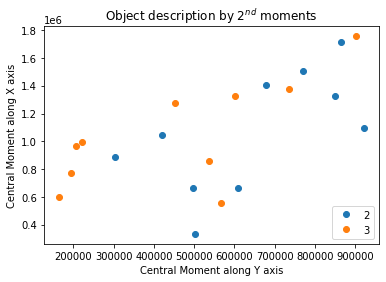

In [18]:
# Compute the 2nd order centerd moments for twos  
centered_moments_vec_twos = compute_moments(twos_im)

# Compute the 2nd order centerd moments for threes 
centered_moments_vec_threes = compute_moments(threes_im)

# Plot the centered moments resutls
twos_c = plt.plot(centered_moments_vec_twos[0],centered_moments_vec_twos[1],"o",label="2")
threes_c  = plt.plot(centered_moments_vec_threes [0],centered_moments_vec_threes [1],"o",label="3")

plt.xlabel('Central Moment along Y axis')
plt.ylabel('Central Moment along X axis')
plt.title('Object description by $2^{nd}$ moments')
plt.legend(loc=4)

plt.show()


__Conclusion__: We see that the this method is not as capable of clustering the images of 2's and 3's as it was for the case of 1's and 0's. The reason is that, in contrast to digits 0 and 1, digits 2 and 3 do not have distictive features along the X and Y axes as long as the $2^{nd}$ moments are concerned and thus the $2ˆ{nd}$ moments cannot be used to define features for images of twos and threes.  

To see if we the moments method is capable of discriminating all 4 digits, we plot all results in a signle plot: 

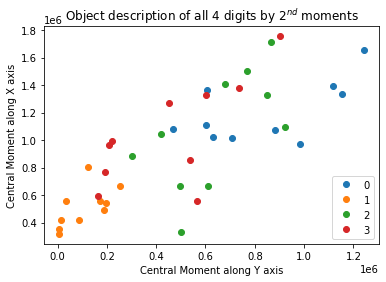

In [17]:
# Plot the centered moments resutls
zeros_c = plt.plot(centered_moments_vec_zeros[0],centered_moments_vec_zeros[1],"o",label="0")
ones_c  = plt.plot(centered_moments_vec_ones [0],centered_moments_vec_ones [1],"o",label="1")
twos_c = plt.plot(centered_moments_vec_twos[0],centered_moments_vec_twos[1],"o",label="2")
threes_c  = plt.plot(centered_moments_vec_threes [0],centered_moments_vec_threes [1],"o",label="3")

plt.xlabel('Central Moment along Y axis')
plt.ylabel('Central Moment along X axis')
plt.title('Object description of all 4 digits by $2^{nd}$ moments')
plt.legend(loc=4)

plt.show()


__Conclusions:__ The $2^{nd}$ centered moments cannot discriminate all 4 digits as we cannot see distictive clusters of digit instances in the above plot. 

#### 2.3.4 Histogram of Oriented Gradients (HoG)

Now, we use HoG described in section 1.3.4 in order to construct image descriptor for images of 2's and 3's. 


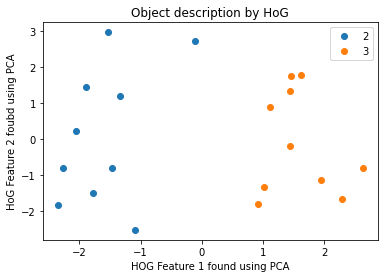

In [10]:
# All features list
all_features_2 = []

# Calculate HoG descriptor with window size of 8x8, cell size of 2x2, and stride of 4x4
HoG_descriptor_2 = cv2.HOGDescriptor((28,28),(8,8),(4,4),(2,2),8)

# Compute the HoG description of twos  
features_twos = compute_HoG_descriptor(twos_im, HoG_descriptor_2)
all_features_2.append(features_twos)

# Compute the HoG description of threes  
features_threes = compute_HoG_descriptor(threes_im, HoG_descriptor_2)
all_features_2.append(features_threes)

# Reshape the features vector from 3D to 2D 
all_features_2 = np.reshape(all_features_2,(np.shape(all_features_2)[0]*np.shape(all_features_2)[1],np.shape(all_features_2)[2]))

# Combine the features using PCA
pca_2 = PCA(n_components=2)
features_2d_2 = pca_2.fit_transform(all_features_2)

# Plot the results
twos = plt.plot(features_2d_2.transpose()[0][10:20],features_2d_2.transpose()[1][10:20],"o", label="2")
threes = plt.plot(features_2d_2.transpose()[0][0:10],features_2d_2.transpose()[1][0:10], "o", label="3")

plt.xlabel('HOG Feature 1 found using PCA')
plt.ylabel('HoG Feature 2 foubd using PCA')
plt.title('Object description by HoG')
plt.legend(loc=1)

plt.show()

__Conclusions:__ According to the above plot, we can see that HoG is capable of extracting features of images of handwritten 2 and 3 digits and can effectively discriminate them and hence we can see two distinguishing clusters among the images of twos and threes. 


Now, we plot all the resutls for all images of 0, 1, 2, and 3 in a single plot to see how the method is capable of discriminating all 4 digits:

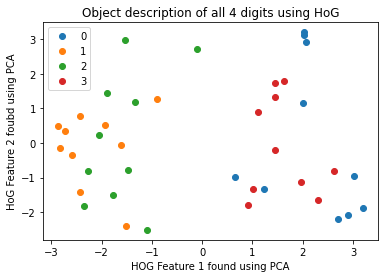

In [11]:
# Plot all HoG results in a single plot
zeros = plt.plot(features_2d.transpose()[0][10:20],features_2d.transpose()[1][10:20],"o", label="0")
ones = plt.plot(features_2d.transpose()[0][0:10],features_2d.transpose()[1][0:10], "o", label="1")
twos = plt.plot(features_2d_2.transpose()[0][10:20],features_2d_2.transpose()[1][10:20],"o", label="2")
threes = plt.plot(features_2d_2.transpose()[0][0:10],features_2d_2.transpose()[1][0:10], "o", label="3")

plt.xlabel('HOG Feature 1 found using PCA')
plt.ylabel('HoG Feature 2 foubd using PCA')
plt.title('Object description of all 4 digits using HoG')
plt.legend(loc=2)

plt.show()

__Conclusions:__ Although HoG could discriminate zeros and ones as well as twos and threes, it is not capable of discriminating all four digits. We observe that there are two (almost) distictive clusters: one containing images of digits 1 and 2 and the other one containing the images of 0 and 3. This is expected because as far as first HoG feature is concerned, digits 1 and 2 look similar and digits 0 and 3 also look alike as 0's and 3's are generally more sensitive to scaling than digits 1 and 2.